In [2]:
%matplotlib inline

In [3]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
texts = ["The caged bird sings with a fearful trill", 
         "for the caged bird sings of freedom"]
cv = CountVectorizer()
d = cv.fit_transform(texts)
# Create a dataframe of the word counts to inspect
# - d.todense() transforms the dtm into a normal (dense) matrix
# - get_feature_names() is a list of the words
pd.DataFrame(d.todense(), columns=cv.get_feature_names()) 

,bird,caged,fearful,for,freedom,of,sings,the,trill,with
0,1,1,1,0,0,0,1,1,1,1
1,1,1,0,1,1,1,1,1,0,0


In [5]:
text = "I haven't seen John's derring-do. Second sentence!"
tokenizer = CountVectorizer().build_tokenizer()
tokens_default = tokenizer(text)
print("Scikit-learn default:", tokens_default)
from nltk.tokenize import TreebankWordTokenizer
tokens_treebank = TreebankWordTokenizer().tokenize(text)
print("Treebank tokenizer:", tokens_treebank)
from nltk import sent_tokenize
def tokenize(text):
    for sent in sent_tokenize(text):
        for token in TreebankWordTokenizer().tokenize(sent):
            yield token
tokens = list(tokenize(text))
print("Treebank tokenizer + sent_tokenize:", tokens)



Scikit-learn default: ['haven', 'seen', 'John', 'derring', 'do', 'Second', 'sentence']
Treebank tokenizer: ['I', 'have', "n't", 'seen', 'John', "'s", 'derring-do.', 'Second', 'sentence', '!']
Treebank tokenizer + sent_tokenize: ['I', 'have', "n't", 'seen', 'John', "'s", 'derring-do', '.', 'Second', 'sentence', '!']


In [6]:
haiku = "\u53e4\u6c60\u86d9\u98db\u3073\u8fbc\u3080\u6c34\u306e\u97f3"
print(f"Default tokens: {tokenizer(haiku)}")
import nagisa
print(f"Nagisa tokens: {nagisa.tagging(haiku).words}")

Default tokens: ['古池蛙飛び込む水の音']
Nagisa tokens: ['古', '池蛙', '飛び込む', '水', 'の', '音']


In [7]:
import pandas as pd

sotu = pd.read_csv("http://cssbook.net/d/sotu.csv")
cv = CountVectorizer(tokenizer=tokenize)
d = cv.fit_transform(sotu["text"])
d

<85x18067 sparse matrix of type '<class 'numpy.int64'>'
	with 136902 stored elements in Compressed Sparse Row format>

In [32]:
import numpy as np
def termstats(dfm, vectorizer):
    """Helper function to calculate term and document frequency per term"""
    # Frequencies are the column sums of the DFM
    frequencies = dfm.sum(axis=0).tolist()[0]
    # Document frequencies are the binned count of the column indices of DFM entries
    docfreqs = np.bincount(dfm.indices)
    freq_df = pd.DataFrame(dict(frequency=frequencies,
                                docfreq=docfreqs), index=vectorizer.get_feature_names())
    return freq_df.sort_values('frequency', ascending=False)

termstats(d, cv).iloc[[0, 10,  100,  1000, 15000]]

ValueError: Shape of passed values is (18067, 2), indices imply (14832, 2)

In [65]:
indices = [cv.vocabulary_[x] for x in ["the", "for", "them", "submit", "sizes."]]
d[[[0], [25], [50], [75]], indices].todense()

matrix([[642,  67,   8,   0,   0],
        [355,  53,   9,   1,   0],
        [182,  56,   5,   0,   0],
        [326,  80,   6,   0,   0]])

(-0.5, 399.5, 199.5, -0.5)

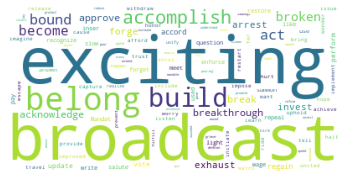

In [105]:
import numpy as np
from wordcloud import WordCloud
from matplotlib import pyplot as plt


def wordcloud(dfm, vectorizer, **options):
    freq_dict = dict(zip(vectorizer.get_feature_names(),
                         dfm.sum(axis=0).tolist()[0]))
    return WordCloud(**options).generate_from_frequencies(freq_dict)

wc = wordcloud(d, cv, background_color="white")
plt.imshow(wc)
plt.axis("off")

In [73]:
url = "https://raw.githubusercontent.com/mkearney/trumptweets/master/data/trumptweets-1515775693.tweets.csv"
tweets = pd.read_csv(url, usecols=["status_id", "text"], index_col="status_id")
tweets.head()

,text
status_id,
x1864367186,Read a great interview with Donald Trump that ...
x9273573134835712,Congratulations to Evan Lysacek for being nomi...
x29014512646,I was on The View this morning. We talked abou...
x7483813542232064,Tomorrow night's episode of The Apprentice del...
x5775731054,Donald Trump Partners with TV1 on New Reality ...


/home/wva/ccsbook/env/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(-0.5, 399.5, 199.5, -0.5)

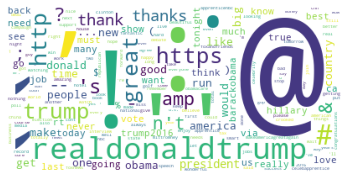

In [74]:
from nltk.corpus import stopwords
cv = CountVectorizer(stop_words=stopwords.words('english'), 
                     tokenizer=TreebankWordTokenizer().tokenize)
d = cv.fit_transform(tweets.text)
wc = wordcloud(d, cv, background_color="white")
plt.imshow(wc)
plt.axis("off")

In [75]:
mystopwords = ["go", "one"] + stopwords.words('english')
print(f"{len(mystopwords)} stopwords: {', '.join(mystopwords[:5])}...")


181 stopwords: go, one, i, me, my...


In [76]:
cv_trim = CountVectorizer(stop_words=stopwords.words('english'), tokenizer=TreebankWordTokenizer().tokenize, max_df=0.75, min_df=0.005)
d_trim = cv_trim.fit_transform(tweets.text)
print(f"# of unique words before trimming: {d.shape[1]}; after trimming: {d_trim.shape[1]}")


/home/wva/ccsbook/env/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


# of unique words before trimming: 50880; after trimming: 303


In [169]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(tokenizer=TreebankWordTokenizer().tokenize, sublinear_tf=True)
d_weighted = tfidf_vectorizer.fit_transform(sotu["text"])
indices = [tfidf_vectorizer.vocabulary_[x] for x in ["the", "for", "them", "submit", "sizes."]]
d_weighted[[[0], [25], [50], [75]], indices].todense()

matrix([[0.00098256, 0.00068509, 0.00041488, 0.        , 0.        ],
        [0.00144943, 0.0010483 , 0.00069021, 0.00036207, 0.        ],
        [0.00143613, 0.00116329, 0.00061826, 0.        , 0.        ],
        [0.00112584, 0.0008928 , 0.00047401, 0.        , 0.        ]])

In [82]:
single_tweet = tweets.text.values[tweets.index == "x263687274812813312"][0]
print(f"Raw:\n{single_tweet}")
tweet_tokens = TreebankWordTokenizer().tokenize(single_tweet)
print(f"\nTokenized:\n{' | '.join(tweet_tokens)}")


Raw:
Part 1 of my @jimmyfallon interview discussing my $5M offer to Obama, #TRUMP Tower atrium, my tweets &amp; 57th st. crane http://t.co/AvLO9Inf

Tokenized:
Part | 1 | of | my | @ | jimmyfallon | interview | discussing | my | $ | 5M | offer | to | Obama | , | # | TRUMP | Tower | atrium | , | my | tweets | & | amp | ; | 57th | st. | crane | http | : | //t.co/AvLO9Inf


In [85]:
import re
single_tweet = re.sub(r"\bhttps?://\S*|&\w+;", "", single_tweet)
tweet_tokens = TreebankWordTokenizer().tokenize(single_tweet)
print(f"After pre-processing:\n {' | '.join(tweet_tokens)}")

After pre-processing:
 Part | 1 | of | my | @ | jimmyfallon | interview | discussing | my | $ | 5M | offer | to | Obama | , | # | TRUMP | Tower | atrium | , | my | tweets | 57th | st. | crane


In [15]:
import regex
tweet_tokens = [t.lower() for t in tweet_tokens 
                if not (t.lower() in stopwords.words('english')
                        or regex.match(r"\P{LETTER}", t))]
print(f"After pruning tokens:\n{' | '.join(tweet_tokens)}")

NameError: name 'tweet_tokens' is not defined

In [102]:
from nltk.tokenize import WhitespaceTokenizer
tokenized_texts = [WhitespaceTokenizer().tokenize(text) for text in tweets.text.values]
tokens = [[t.lower() for t in tokens 
           if regex.match("#", t) ]
          for tokens in tokenized_texts]
def do_nothing(x):
    return x
cv = CountVectorizer(tokenizer=do_nothing, lowercase=False)
dtm_emoji = cv.fit_transform(tokens)
wc = wordcloud(dtm_emoji, cv, background_color="white")
plt.imshow(wc)
plt.axis("off")

NameError: name 'tweets' is not defined

In [9]:
import os
import urllib.request
glove_fn = 'glove.6B.50d.10k.w2v.txt'
url = f'http://cssbook.net/d/{glove_fn}'
if not os.path.exists(glove_fn):
      urllib.request.urlretrieve (url, glove_fn)

In [55]:
from gensim.models import KeyedVectors
wv = KeyedVectors.load_word2vec_format(glove_fn)
wvdf = pd.DataFrame(wv.vectors, index=wv.vocab)
wvdf.sort_values(0, ascending=False).head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
airbus,2.5966,-0.53562,0.41422,0.339390,-0.050989,0.84761,-0.72224,-0.36125,0.86917,-0.73059,...,0.54601,-0.25080,1.31020,-0.24175,-0.30980,1.14690,-0.803920,1.505000,-0.066982,0.133350
spacecraft,2.5187,0.74418,1.66480,0.059079,-0.252150,-0.24264,-0.59439,-0.41732,0.45961,-0.12370,...,0.18188,-0.93961,0.86213,-0.52732,-0.71251,-0.30863,1.054500,-0.065039,-0.235400,-0.401210
fiat,2.2865,-1.14970,0.48850,0.518330,0.311980,-0.13188,0.05203,-0.66095,-0.85899,0.26276,...,-0.17639,-0.85392,0.35823,-0.69644,-0.31383,0.33382,-0.732300,0.173990,0.398950,0.042601
naples,2.2656,-0.10631,-1.27220,-0.093226,-0.437000,-1.18090,-0.08577,0.46925,-1.08410,-0.54926,...,0.01893,0.62688,0.54075,-0.58529,-0.42509,0.67343,-0.152420,-0.857650,0.211240,-0.279690
di,2.2441,-0.60324,-1.46890,0.354340,0.243670,-1.08890,0.35689,-0.33070,-0.56399,0.42835,...,0.46470,0.26903,-0.36234,-0.94564,-0.19706,-1.19640,0.000371,-1.229200,0.805580,0.775450


In [52]:
wv.most_similar('fraud')

[('charges', 0.8591152429580688),
 ('bribery', 0.8559849858283997),
 ('alleged', 0.8415062427520752),
 ('corruption', 0.8299386501312256),
 ('allegations', 0.8191748261451721),
 ('theft', 0.802556037902832),
 ('criminal', 0.7997947931289673),
 ('investigating', 0.792083740234375),
 ('investigation', 0.7885714173316956),
 ('laundering', 0.7872843146324158)]

In [53]:
def analogy(a, b, c):
    result = wv.most_similar(positive=[b, c], negative=[a])
    return result[0][0]

for x in ["king", "boy", "father", "pete", "football"]:
    print(f"Man is to {x} as woman is to {analogy('man', x, 'woman')}")

Man is to king as woman is to queen
Man is to boy as woman is to girl
Man is to father as woman is to mother
Man is to pete as woman is to barbara
Man is to football as woman is to soccer


In [26]:
tokenized_texts = [tokenize(t) for t in sotu.text]
tokens = [[t.lower() for t in tokens 
           if not regex.search("\P{letter}", t) ]
           for tokens in tokenized_texts]

In [19]:
from gensim.models import Phrases
p = Phrases(tokens, min_count=10, scoring="npmi", threshold=.5)
score_data = [(w1.decode('utf-8'), w2.decode('utf-8'), score) 
              for (w1, w2), score in set(p.export_phrases(tokens, as_tuples=True))]
scores = pd.DataFrame(score_data, columns=['word1', 'word2', 'score'])
scores.sort_values("score", ascending=False).head()

collecting all words and their counts
PROGRESS: at sentence #0, processed 0 words and 0 word types
collected 200027 word types from a corpus of 578783 words (unigram + bigrams) and 85 sentences
using 200027 counts as vocab in Phrases<0 vocab, min_count=10, threshold=0.5, max_vocab_size=40000000>


,word1,word2,score
5,iron,curtain,0.977816
420,saddam,hussein,0.975395
252,al,qaida,0.963029
325,red,tape,0.952860
58,persian,gulf,0.951335


In [37]:
from gensim.sklearn_api.phrases import PhrasesTransformer
pt = PhrasesTransformer(min_count=10, threshold=.7, scoring="npmi")
tokens_phrases = pt.fit_transform(tokens)
cv = CountVectorizer(tokenizer=lambda x: x, lowercase=False)
dtm = cv.fit_transform(tokens_phrases)
termstats(dtm, cv).filter(like="hussein", axis=0)



collecting all words and their counts
PROGRESS: at sentence #0, processed 0 words and 0 word types
collected 200027 word types from a corpus of 578783 words (unigram + bigrams) and 85 sentences
using 200027 counts as vocab in Phrases<0 vocab, min_count=10, threshold=0.7, max_vocab_size=40000000>
source_vocab length 200027
Phraser built with 87 phrasegrams


,frequency,docfreq
saddam_hussein,29,5


In [12]:
udpipe_model = "english-ewt-ud-2.4-190531.udpipe"
url = "https://raw.githubusercontent.com/jwijffels/udpipe.models.ud.2.4/master/inst/udpipe-ud-2.4-190531/english-ewt-ud-2.4-190531.udpipe"
if not os.path.exists(udpipe_model):
    urllib.request.urlretrieve(url, udpipe_model)

In [13]:
from ufal.udpipe import Model, Pipeline
import conllu
m = Model.load(udpipe_model)
pipeline = Pipeline(m, "tokenize", Pipeline.DEFAULT, Pipeline.DEFAULT, "conllu")
tokenlist = conllu.parse(pipeline.process(sotu.text.values[-1])) 
tokens = pd.concat([pd.DataFrame(t).assign(sentence=i) for (i, t) in enumerate(tokenlist)])
tokens.head()

,id,form,lemma,upos,xpos,feats,head,deprel,deps,misc,sentence
0,1,Madam,Madam,PROPN,NNP,{'Number': 'Sing'},0,root,None,None,0
1,2,Speaker,speaker,PROPN,NNP,{'Number': 'Sing'},1,flat,None,{'SpaceAfter': 'No'},0
2,3,",",",",PUNCT,",",None,1,punct,None,None,0
3,4,Mr.,Mr.,PROPN,NNP,{'Number': 'Sing'},1,appos,None,None,0
4,5,Vice,vice,PROPN,NNP,{'Number': 'Sing'},4,flat,None,None,0


(-0.5, 399.5, 199.5, -0.5)

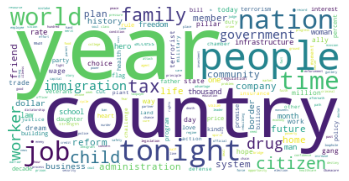

In [108]:
def get_nouns(text):
    for sentence in conllu.parse(pipeline.process(text)):
        for token in sentence:
            if token['upos'] == "NOUN":
                yield token['lemma']
tokens = [list(get_nouns(text)) for text in sotu.text[-3:-1]]
cv = CountVectorizer(tokenizer=lambda x: x, lowercase=False)
dtm_verbs = cv.fit_transform(tokens)
wc = wordcloud(dtm_verbs, cv, background_color="white")
plt.imshow(wc)
plt.axis("off")